# How can we tell whether a game is good? 
We will investigate the features that affect how good a game is (rating).

<a class="anchor" id="0"></a>
   * 1 [Exploratory Data Analysis](#1)
       * 1.1 [Feature Engineering](#1.1)
   * 2 [Regression Models](#2)
       * 2.1 [Linear Regression](#2.1)
       * 2.2 [KNN Regression](#2.2)
       * 2.3 [Random Forest Regression](#2.3)
       * 2.4 [Gradient Boosting + Optimizing Hyperparameters](#2.4)
       * 2.5 [Including TF-IDF](#2.5)
   * 3 [Classification Models](#3)
       * 3.1 [Logistic Regression](#3.1)
       * 3.2 [Random Forest Classification](#3.2)
   * 4 [Conclusion](#4)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

In [2]:
data = pd.read_csv("steamdata_clean.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25306 entries, 0 to 25305
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                25306 non-null  object 
 1   steam_appid         25306 non-null  int64  
 2   controller_support  25306 non-null  int64  
 3   dlc                 25306 non-null  int64  
 4   short_description   25292 non-null  object 
 5   demos               25306 non-null  int64  
 6   platforms           25306 non-null  object 
 7   movies              25306 non-null  int64  
 8   achievements        25306 non-null  int64  
 9   release_date        25306 non-null  object 
 10  genres              25306 non-null  object 
 11  developer           25306 non-null  object 
 12  publisher           25306 non-null  object 
 13  owners              25306 non-null  object 
 14  average_forever     25306 non-null  int64  
 15  median_forever      25306 non-null  int64  
 16  init

In [3]:
# fill null with blank descriptions
data["short_description"] = data["short_description"].fillna("")

In [4]:
# convert owners category into midpoint
owners_split = data["owners"].str.replace(',', '').str.split(' .. ')
data["owners"] = owners_split.apply(lambda x: (int(x[0]) + int(x[1])) // 2)

<a class="anchor" id="1"></a>
# Exploratory Data Analysis

## Brief Overview on Games

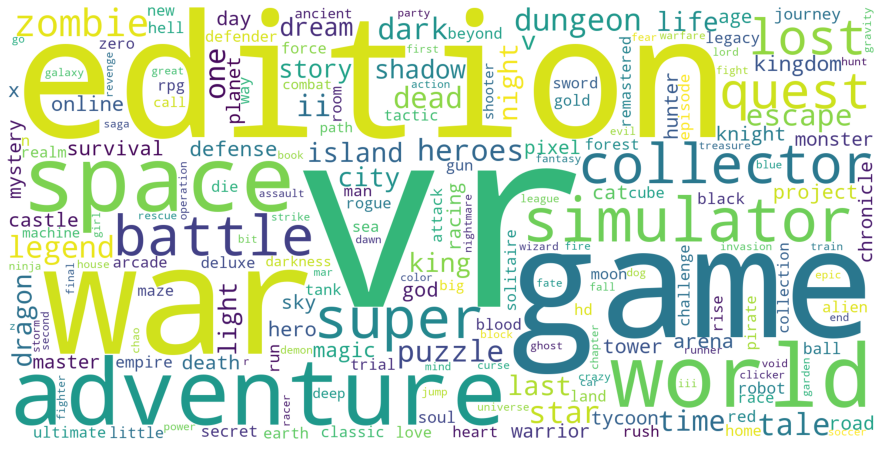

In [5]:
# fancy wordcloud to see commonly used words in game titles

from wordcloud import WordCloud, STOPWORDS
import re
from nltk.corpus import stopwords

sw = set(stopwords.words('english'))
# clean residuals from text formatting
newStopWords = ["amp", "quot"]
sw = sw.union(newStopWords)

def clean_text(sample):
    sample = sample.lower()
    
    # remove formatting, punctuation
    sample = sample.replace("<br /><br />", "")
    sample = re.sub("[^a-zA-Z]+", " ", sample)
    
    sample = sample.split()
    
    sample = " ".join(sample)
    
    return sample

data["name_clean"] = data["name"].apply(clean_text)
name_corpus = ' '.join(data["name_clean"])
name_wordcloud = WordCloud(stopwords = sw, background_color = 'white', height = 1000, width = 2000).generate(name_corpus)
plt.figure(figsize=(16,8))
plt.imshow(name_wordcloud)
plt.axis('off')
plt.show()

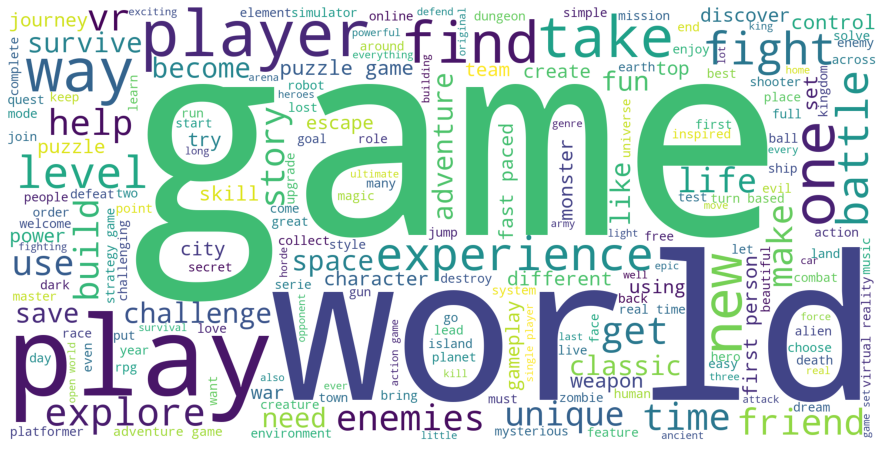

In [6]:
# wordcloud of game descriptions
data["description_clean"] = data["short_description"].apply(clean_text)
description_corpus = ' '.join(data["description_clean"])
description_wordcloud = WordCloud(stopwords = sw, background_color = 'white', height = 1000, width = 2000).generate(description_corpus)
plt.figure(figsize=(16,8))
plt.imshow(description_wordcloud)
plt.axis('off')
plt.show()

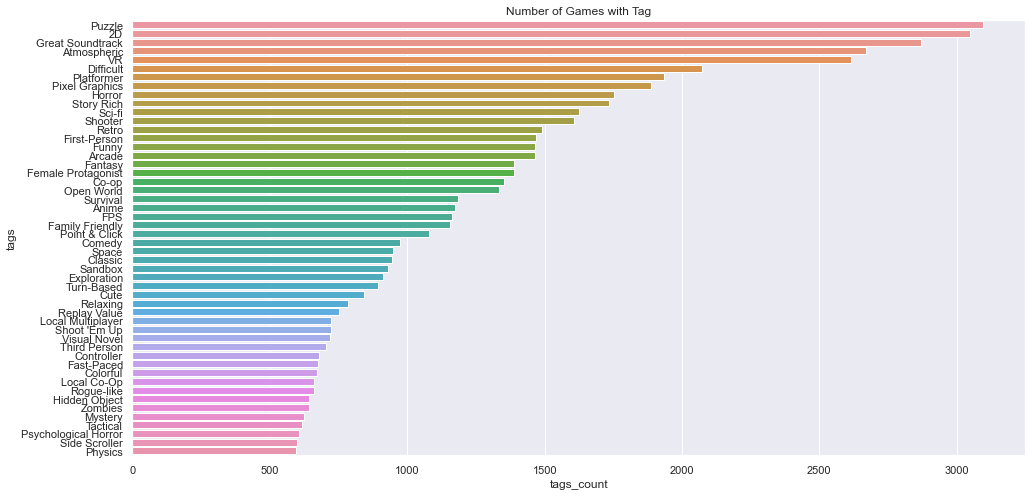

In [7]:
tags_count = pd.DataFrame(data.additional_tags.str.split(';').explode().value_counts()).reset_index()
tags_count.columns = ["tags", "tags_count"]
tags_count = tags_count[(tags_count["tags"] != "Singleplayer") & (tags_count["tags"] != "Multiplayer") & (tags_count["tags"] != "NSFW")]

f = plt.figure(figsize=(16, 8))
sb.barplot(x = "tags_count", y = "tags", data = tags_count.head(50))
plt.title("Number of Games with Tag");

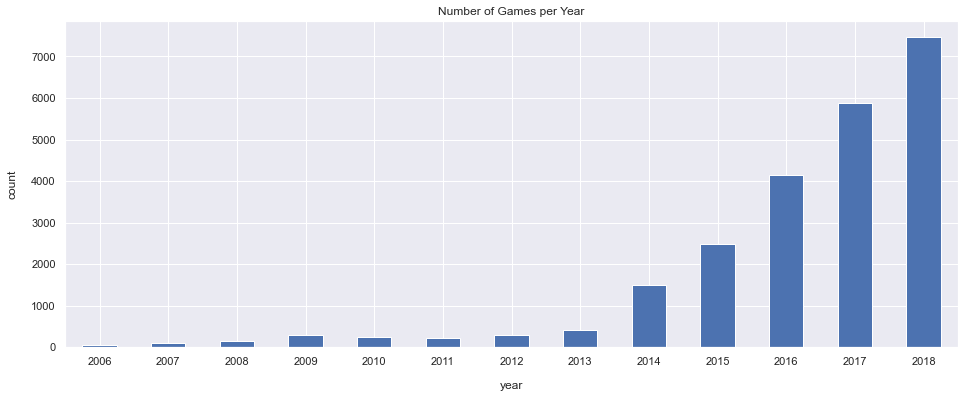

In [8]:
# convert release date to year
data["year"] = pd.to_datetime(data["release_date"]).dt.year

year_count = pd.DataFrame(data = data["year"].value_counts().sort_index())
year_count = year_count.loc[2006:2018]
f = plt.figure(figsize=(16, 6))
year_count["year"].plot(kind = "bar", rot = 0);
plt.xlabel("year", labelpad=14)
plt.ylabel("count", labelpad=14)
plt.title("Number of Games per Year");

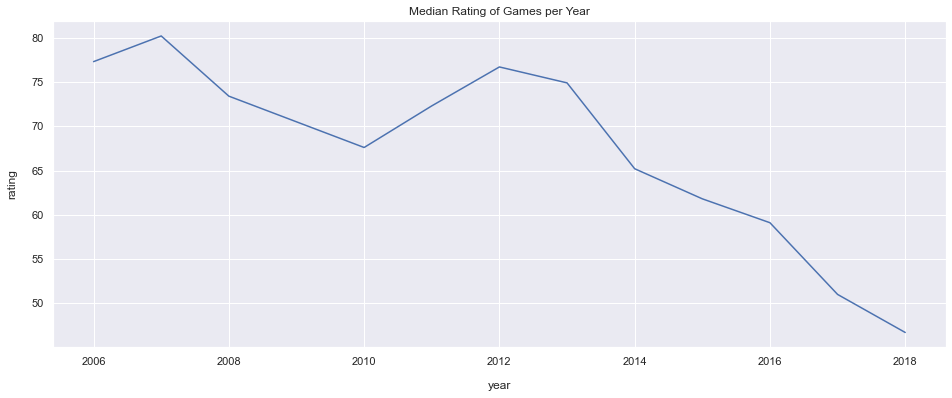

In [9]:
rating_trend = pd.DataFrame(data = data["rating"].groupby(data["year"]).median())
rating_trend = rating_trend.loc[2006:2018]
f = plt.figure(figsize=(16, 6))
rating_trend["rating"].plot(kind = "line", rot = 0);
plt.xlabel("year", labelpad=14)
plt.ylabel("rating", labelpad=14)
plt.title("Median Rating of Games per Year");

OH NO! Are games getting worse? :(

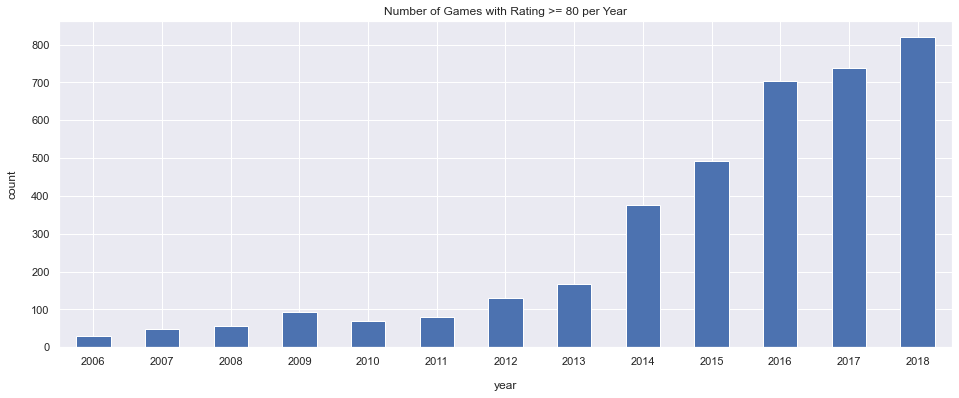

In [10]:
gg_trend = pd.DataFrame(data[data["rating"] >= 80]["rating"].groupby(data["year"]).count().loc[2006:2018])
f = plt.figure(figsize=(16, 6))
gg_trend["rating"].plot(kind = "bar", rot = 0);
plt.xlabel("year", labelpad=14)
plt.ylabel("count", labelpad=14)
plt.title("Number of Games with Rating >= 80 per Year");

Phew, false alarm... Nope, the number of good games are increasing!
- The decrease in median rating of games over time is possibly due to the over-saturation of low-quality games and smaller releases now. The entry cost of creating games are much lower and tools to create games are more accessible now, anyone and not just game companies can start making games. Hence even though the number of good games are increasing, it is still a small proportion compared to the total number of games released.

In [11]:
data[["name", "developer", "genres", "initialprice", "rating", "year", "owners"]].sort_values("rating", ascending = False).head(20)

,name,developer,genres,initialprice,rating,year,owners
23,Portal 2,Valve,Action;Adventure,9.99,98.6,2011,15000000
7312,Factorio,Wube Software LTD.,Casual;Indie;Simulation;Strategy;Early Access,30.00,98.4,2016,1500000
2255,One Finger Death Punch,Silver Dollar Games,Action;Casual;Indie,4.99,98.0,2014,750000
7248,Iron Snout,SnoutUp,Action;Free to Play;Indie,0.00,97.8,2016,1500000
17,Portal,Valve,Action,9.99,97.8,2007,15000000
6885,TY the Tasmanian Tiger,Krome Studios,Action;Adventure;Indie,14.99,97.8,2016,75000
4236,Finding Paradise,Freebird Games,Adventure;Indie;RPG,9.99,97.8,2017,350000
7144,OneShot,Little Cat Feet,Adventure;Casual;Indie,9.99,97.8,2016,350000
2980,RimWorld,Ludeon Studios,Indie;Simulation;Strategy,34.99,97.7,2018,1500000
2014,A Hat in Time,Gears for Breakfast,Adventure;Indie,29.99,97.7,2017,350000


Taking a look at the **top 20 games**, Action, Adventure, Indie seem to be common genres of top games. Notably, only 1 is a free-to-play game.

In [12]:
# we will only look at 'main' genres of games, since some titles on steam w/ genres eg. Photo Editing arent really games
genre_cols = ["Action",
            "Adventure",
            "Casual",
            "Indie",
            "Massively Multiplayer",
            "RPG",
            "Racing",
            "Simulation",
            "Sports",
            "Strategy"]

## Investigating Genres
We will perform **Dummy Encoding** on our categorical genres and additional tags data. Then, we will observe the rating distribution across genres.

In [13]:
# dummy encoding for additional tags
tags_encoding = data.additional_tags.str.split(';').explode().str.get_dummies().groupby(level=0).sum()

In [14]:
# dummy encoding for genres
genre_encoding = data["genres"].str.get_dummies(';').filter(genre_cols)
genre_encoding

,Action,Adventure,Casual,Indie,Massively Multiplayer,RPG,Racing,Simulation,Sports,Strategy
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
25301,0,1,1,1,0,0,0,0,0,0
25302,1,1,0,1,0,0,0,0,0,0
25303,1,0,1,1,0,0,0,0,0,0
25304,0,1,1,1,0,0,0,0,0,0


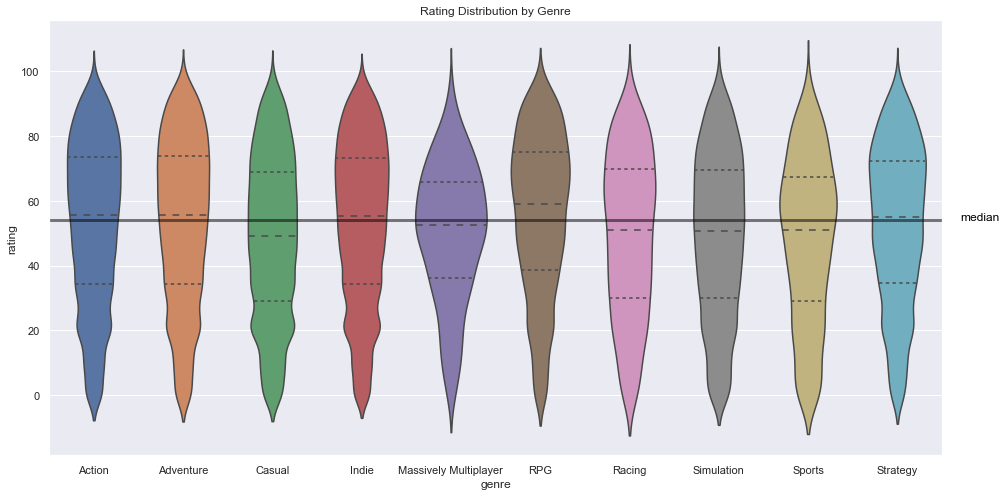

In [15]:
genres_df = data[["steam_appid", "rating", "initialprice"]]
genres_df = pd.concat([genres_df, genre_encoding], axis = "columns")

genres_data = pd.DataFrame()
# create new dataframe with each entry of genre to respective rating, as games can belong to multiple genres
for col in genre_cols:
    ratings = pd.DataFrame(genres_df.loc[genres_df[col] == 1, "rating"].values, columns = ["rating"])
    ratings["genre"] = col
    genres_data = pd.concat([genres_data, ratings], axis = 0)

fig, ax = plt.subplots(figsize=(16, 8))
sb.violinplot(x = "genre", y = "rating", data = genres_data, inner = "quartile", ax = ax)
ax.set_title("Rating Distribution by Genre")
ax.axhline(genres_data.rating.median(), color = "black", lw = 3, alpha = 0.5)
ax.text(9.7, genres_data.rating.median(), "median", color = 'black')
plt.show()

Not much variations in rating across genres, maybe because of how games can and often have multiple genres. eg. Action games usually come together with Adventure

- Massively Multiplayer games are mostly distributed around its median and tend to have much lower ratings than other genres 
- Racing, Simulation, Sports games have slightly lower ratings than most genres
- RPG games have much higher ratings than other genres
- Casual games have much lower ratings than other genres

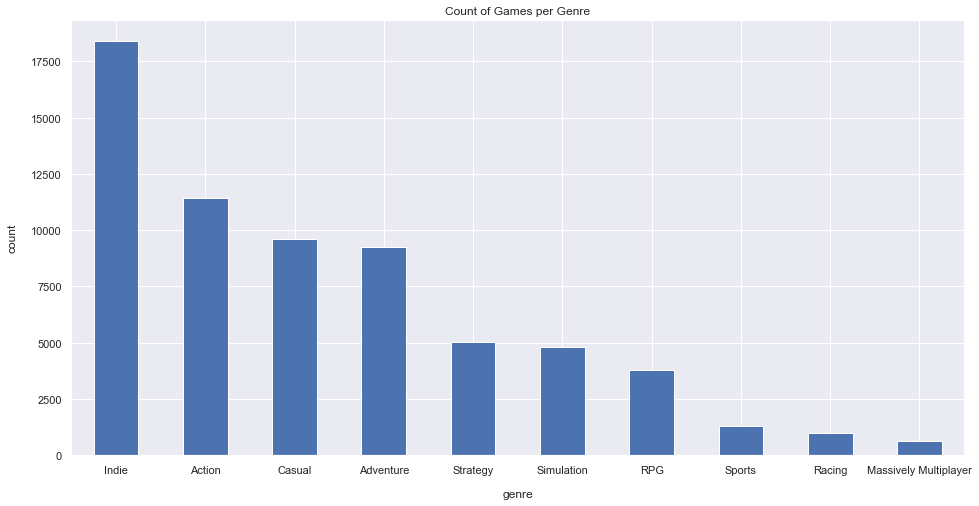

In [16]:
f = plt.figure(figsize=(16, 8))
genres_data["genre"].value_counts().plot(kind = "bar", rot = 0);
plt.xlabel("genre", labelpad=14)
plt.ylabel("count", labelpad=14)
plt.title("Count of Games per Genre");

- Massively Multiplayer games are fewest
- Very few Sports and Racing games
- A lot of Indie games aka games by non-AAA developers, meaning smaller development studios or solo-devs 

## Investigating Developers
We will use the ratings of games made by a developer to determine the score of that developer.
- However, developers have different number of games created. eg. A developer that has only 1 highly rated game (rating: 90) should not be considered as good as a developer that have 3 highly rated games (ratings: 90, 90, 90). 

Hence we will use **Bayesian Averaging** to also take into account the sample size when ranking a developer.

![Bayesian Average](https://i.stack.imgur.com/g9uew.png)
- S = score of dev
- R = average of game ratings for the dev
- C = average of game ratings for all devs
- w = weight assigned to R and computed as v/(v+m), where v = number of game ratings for that dev, m = average number of game ratings for all devs

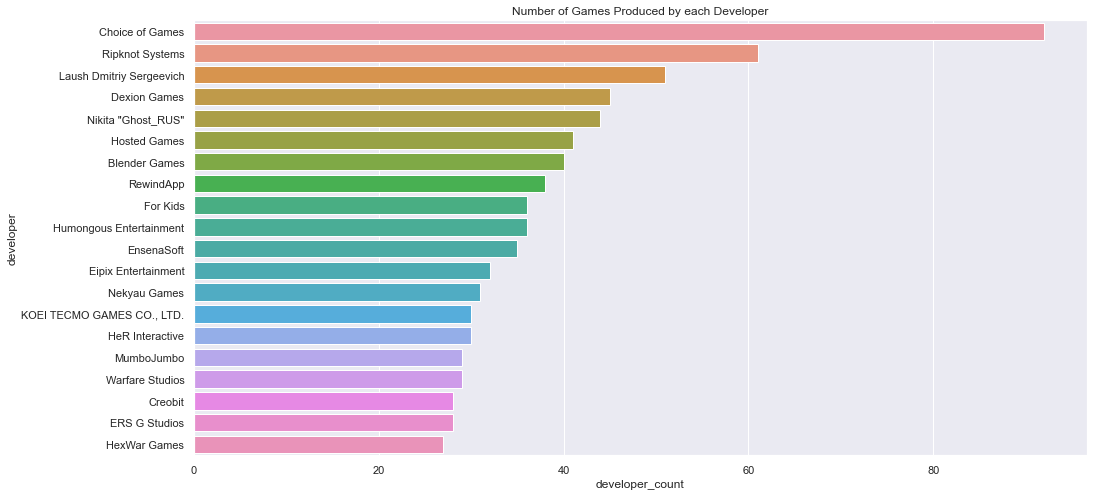

In [17]:
developer_count = pd.DataFrame(data.developer.str.split(';').explode().value_counts()).reset_index()
developer_count.columns = ["developer", "developer_count"]

f = plt.figure(figsize=(16, 8))
sb.barplot(x = "developer_count", y = "developer", data = developer_count.head(20))
plt.title("Number of Games Produced by each Developer");

In [18]:
# get top developers by scoring using Bayesian Average: S = wR + (1-w)C
# S = score of dev
# R = average of game ratings for the dev
# C = average of game ratings for all devs
# W = weight assigned to R and computed as v/(v+m), 
# where v = number of game ratings for that dev, m = average number of game ratings for all devs

developer_df = data[["rating", "developer"]]
ratings = developer_df.groupby(["developer"])["rating"].apply(list)
ratings = pd.DataFrame(ratings)
ratings = ratings.merge(developer_count, on = "developer")

ratings["R"] = ratings["rating"].apply(lambda x: sum(x)/len(x))
C = ratings["rating"].apply(lambda x: sum(x)).sum() / ratings["developer_count"].sum()
M = ratings["developer_count"].sum() / ratings.shape[0]
ratings["W"] = ratings["developer_count"] / (ratings["developer_count"]+M)
ratings["S"] = ratings["W"]*ratings["R"] + (1 - ratings["W"])*C

developer_data = ratings[["developer", "S"]]
developer_data = developer_data.rename(columns = {"S":"score"})

developer_data.sort_values(by = "score", ascending = False).head(20)

,developer,score
14357,Valve,86.205376
8,07th Expansion,85.901044
9314,Nihon Falcom,85.445068
9279,Nickervision Studios,85.284050
2977,Croteam,85.095288
11142,Relic Entertainment,85.033024
14669,Wadjet Eye Games,84.468218
11791,Scott Cawthon,84.133517
1055,Artifex Mundi,82.318785
11513,Rusty Lake,82.107559


## Other Categorical Variables

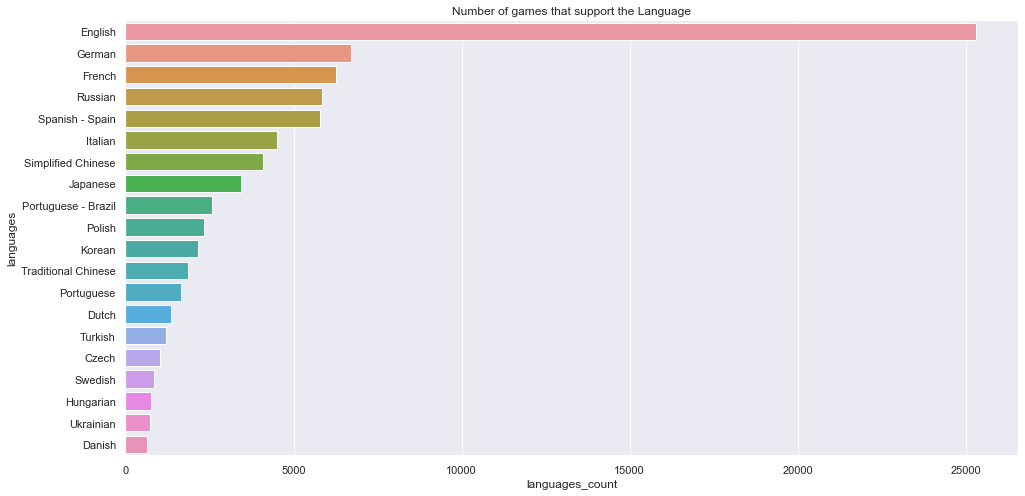

In [19]:
languages_count = pd.DataFrame(data.languages.str.split(';').explode().value_counts()).reset_index()
languages_count.columns = ["languages", "languages_count"]

f = plt.figure(figsize=(16, 8))
sb.barplot(x = "languages_count", y = "languages", data = languages_count.head(20))
plt.title("Number of games that support the Language");

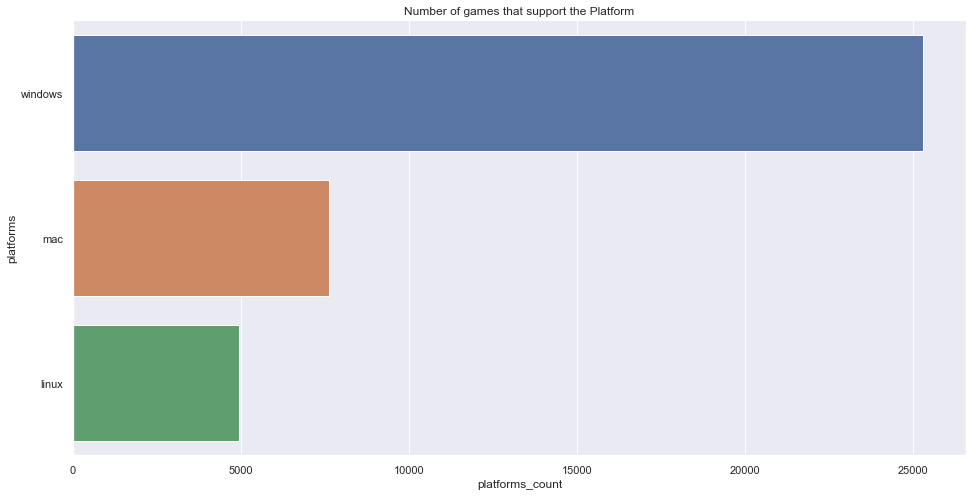

In [20]:
platforms_count = pd.DataFrame(data.platforms.str.split(';').explode().value_counts()).reset_index()
platforms_count.columns = ["platforms", "platforms_count"]

f = plt.figure(figsize=(16, 8))
sb.barplot(x = "platforms_count", y = "platforms", data = platforms_count.head(20))
plt.title("Number of games that support the Platform");

## Investigating Numeric Variables

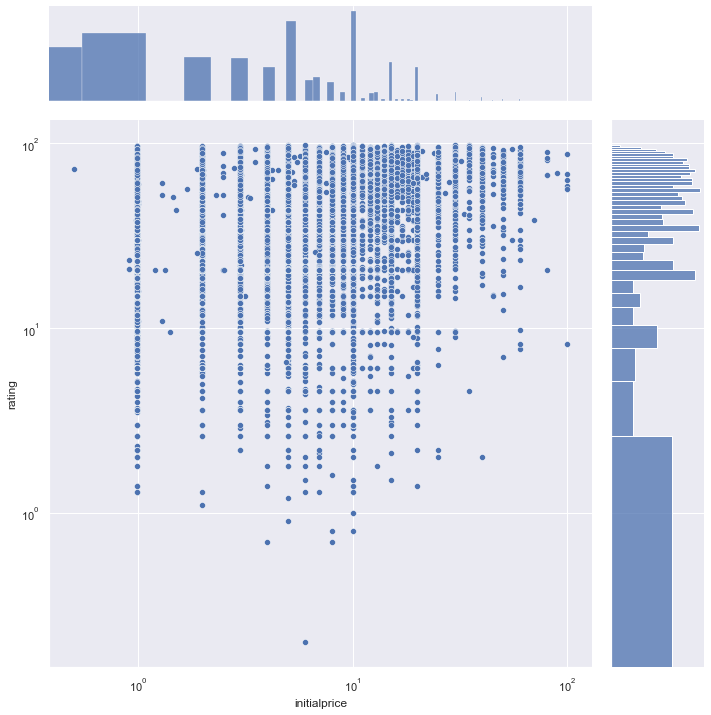

In [21]:
# remove extreme outliers distorting the scale
price_df = pd.concat([data[data["initialprice"] < 199]["initialprice"], data["rating"]], axis = 1)
g = sb.jointplot(data = price_df, x = "initialprice", y = "rating", height = 10)

# datapoints are clustered, set as logarithmic graph to better visualize the relationship
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

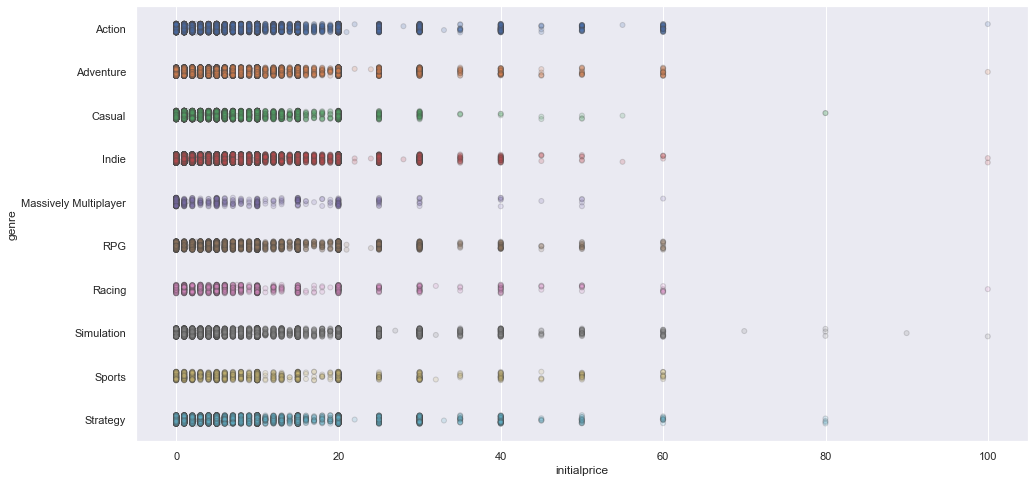

In [22]:
prices_data = pd.DataFrame()

for col in genre_cols:
    prices = pd.DataFrame(genres_df.loc[genres_df[col] == 1, "initialprice"].values, columns = ["initialprice"])
    prices["genre"] = col
    prices_data = pd.concat([prices_data, prices], axis = 0)
    
# remove extreme outliers distorting the scale
prices_data = prices_data[prices_data["initialprice"] < 100]
f = plt.figure(figsize=(16, 8))
ax = sb.stripplot(x="initialprice", y="genre", data=prices_data, jitter=True, alpha=0.2, linewidth=1);

Most games are priced below 20 dollars, almost all games are priced at 60 dollars or less.
- Games which are Massively Multiplayer tend to be free or cheaper, mainly because of the business model (free-to-play or low entry cost but huge amount of in-game microtransactions)

<a class="anchor" id="1.1"></a>
## Feature Engineering
- In our dataset, in our categorical data: there are 10 genres, over 300 additional tags, over 16000 developers, and over 13000 publishers. The large number of additional tags, developers and publishers are not really useful as features in our model. Furthermore, most developers and publishers have not made many games and so it is hard to learn anything about them. Hence we decide to discard `developer`, `publisher` in our models.
- For this analysis, we will not take into account the playtime and number of owners. This is because we want to take into account the inherent 'goodness' of the game itself. eg. There might be games that are under-rated or not as widely marketed, or short games (for instance: a replayable Battle Royale vs. Story-based game with definitive ending). Hence these games may not have as many owners or as much playtime, but people may still consider them as very good games. Furthermore, we want to predict whether a new game will be good, hence such information will not be known before the game has released.

In [23]:
# get relevant columns
var = data[["steam_appid", "controller_support", "dlc", "demos", "movies", "achievements", "is_multiplayer", "initialprice", "rating", "year", "owners", "description_clean", "name_clean"]].copy()

In [24]:
# platforms -> no. of platforms supported, languages -> no. of languages supported
var["platforms"] = data["platforms"].apply(lambda x: len(x.split(';')))
var["languages"] = data["languages"].apply(lambda x: len(x.split(';')))

In [25]:
var = pd.concat([var, genres_df], axis = "columns")
var = var.loc[:,~var.columns.duplicated()]

In [26]:
# get additional tag columns
var = pd.concat([var, tags_encoding], axis = "columns")

In [27]:
# drop games with extreme outliers
cols = ["achievements", "initialprice", "languages", "platforms", "rating", "owners"]

Q1 = var[cols].quantile(0.01)
Q3 = var[cols].quantile(0.99)
IQR = Q3 - Q1 # inter-quartile range

var = var[~((var[cols] < (Q1 - 1.5 * IQR)) | (var[cols] > (Q3 + 1.5 * IQR))).any(axis = 1)].reset_index(drop = True)

<AxesSubplot:>

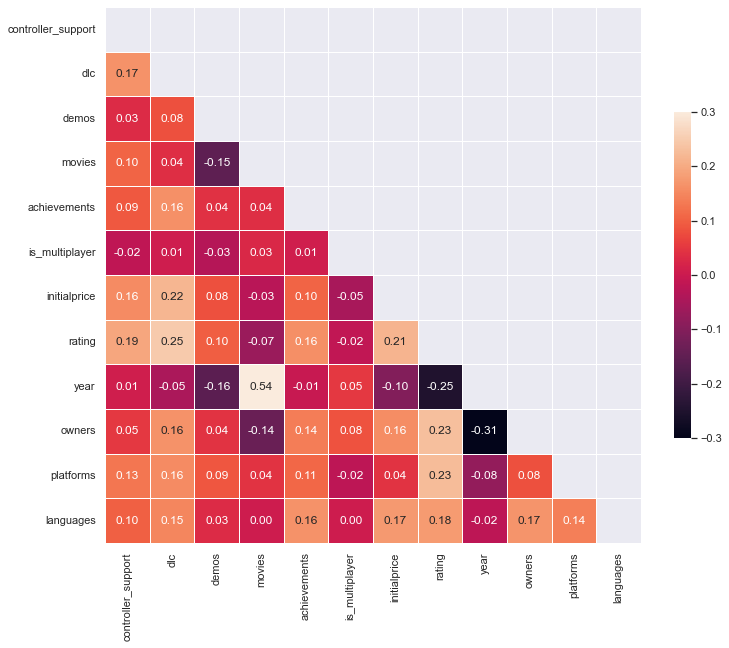

In [28]:
var_corr = var.loc[:,"controller_support":"languages"].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(var_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(var_corr, mask=mask, cmap="rocket", vmin = -0.3, vmax = 0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

Notable observations:
- `controller_support`, `dlc`, `demos`, `achievements`, `initialprice`, `platforms`, `languages` seem to be correlated with rating. Surprisingly, whether a game `is_multiplayer` has almost no correlation to its rating.

<AxesSubplot:>

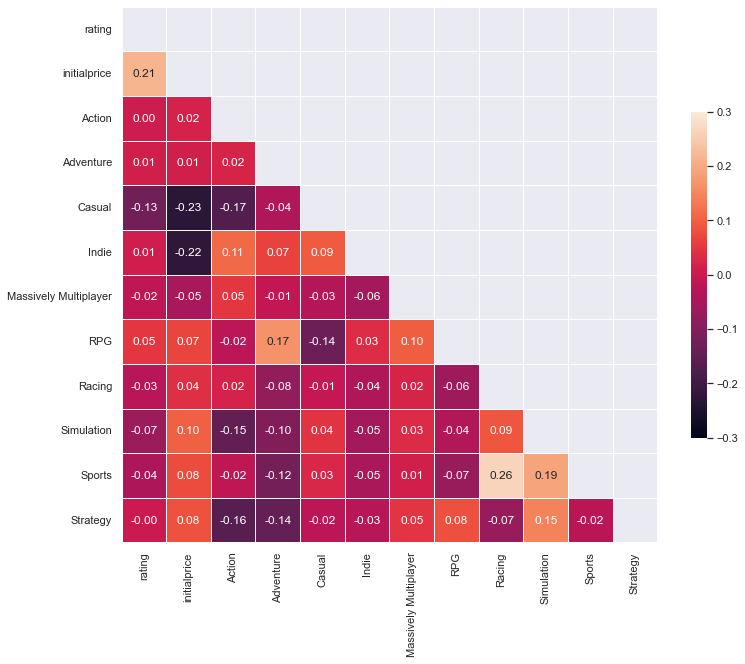

In [29]:
# Compute the correlation matrix
var_corr = pd.concat([var[["rating", "initialprice"]], var.loc[:,"Action":"Strategy"]], axis = "columns").corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(var_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(var_corr, mask=mask, cmap="rocket", vmin = -0.3, vmax = 0.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt = ".2f")

Notable observations:
- `rating` does not really seem to have much correlation with the different genres, except for being negatively correlated with `Casual`. Maybe Casual games are usually of lower quality?
- Certain relationships between genres can be seen. For example, `Sports` games usually come with `Racing` and `Simulation`, `RPG` games usually come with `Adventure`.
- `Casual` and `Indie` games are negatively correlated with `initialprice`, implying that these games are cheaper.

<a class="anchor" id="2"></a>
# Regression Models 

Now, we will see if we can predict the `rating` of a game, and investigate what could be the most important features in determining higher ratings.
- First, we will do **Feature Selection** to reduce the number of our input variables using `SelectKBest`. This is to reduce the computational cost of modeling. We will then **standardize** the data using `StandardScaler` to account for input values with differing scales.
- We will do a 80:20 `train_test_split` for our data and investigate the performance of various regression models, while doing **k-fold Cross Validation**. K-fold Cross Validation partitions the data to build a more generalized model.

In [30]:
# X is inputs, y is output
X = var.drop(["rating", "steam_appid", "year", "owners", "description_clean", "name_clean"], axis = 1)
y = var["rating"] 

### Feature Selection

In [31]:
# feature selection
from sklearn.feature_selection import f_regression, SelectKBest

X = X.drop(["Singleplayer", "Multiplayer"], axis = "columns")
# select top 20 input variables based on feature importance
select = SelectKBest(score_func = f_regression, k = 20)
features_data = select.fit_transform(X, y)
top_features = select.get_support()
X = pd.DataFrame(features_data, columns = select.feature_names_in_[top_features])
features = pd.DataFrame(select.scores_, columns = ["score"], index = select.feature_names_in_).sort_values("score", ascending = False)

In [32]:
# selected top features
features.head(20)

,score
Great Soundtrack,2214.398376
dlc,1644.280463
platforms,1348.745638
initialprice,1205.006330
2D,1110.721748
Story Rich,1049.246363
controller_support,967.448950
Pixel Graphics,850.934465
Atmospheric,845.302054
languages,811.481991


Interesting, seems like these are the top features in determining the rating of a game!

In [33]:
from sklearn.model_selection import train_test_split

# Splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69) 

<a class="anchor" id="2.1"></a>
### Linear Regression
Linear regression is a linear model that assumes a linear relationship between the input variables X and the output variable y.

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# K-Fold cross validation technique
validation_type = KFold(n_splits = 10, random_state = 69, shuffle = True)

# Cross validation score of Linear Regression model
cv_lr_train = cross_val_score(lr, X_train, y_train, cv = validation_type, scoring = "r2")
cv_lr_test = cross_val_score(lr, X_test, y_test, cv = validation_type, scoring = "r2")
print(f"train: {cv_lr_train}")
print(f"test: {cv_lr_test}")
print()
print(f"Linear Regression R^2 (train): {cv_lr_train.mean():.3f}")
print(f"Linear Regression R^2 (test): {cv_lr_test.mean():.3f}")

train: [0.25322718 0.2561296  0.22586227 0.24512779 0.24463799 0.247768
 0.21747459 0.24977149 0.22007791 0.25109908]
test: [0.22538879 0.2368988  0.21623331 0.15987804 0.21396838 0.24270709
 0.24253595 0.22620266 0.22627459 0.25134795]

Linear Regression R^2 (train): 0.241
Linear Regression R^2 (test): 0.224


In [37]:
from sklearn.metrics import mean_squared_error

# Predict test set and calculate mean squared error
lr_predict = lr.predict(X_test)
print(f"Linear Regression MSE (test): {mean_squared_error(y_test, lr_predict):.3f}")
print(f"Linear Regression RMSE (test): {np.sqrt(mean_squared_error(y_test, lr_predict)):.3f}")
print(f"Intercept of regression: {lr.intercept_:3f}")
print(f"Coefficients of regression:", lr.coef_)

Linear Regression MSE (test): 500.565
Linear Regression RMSE (test): 22.373
Intercept of regression: 52.739693
Coefficients of regression: [1.68197847 2.44335725 1.63555141 2.57431837 3.07753036 1.42124527
 0.68296443 1.78787062 0.24311606 2.47825551 1.57680598 1.12569699
 0.45484225 1.10547531 1.10337282 2.01129777 2.44963455 2.35712679
 1.10613452 1.185441  ]


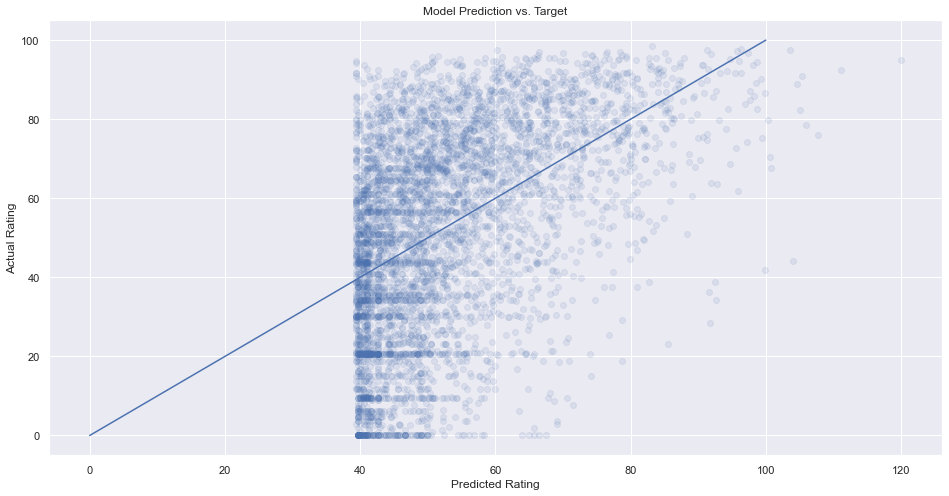

In [38]:
f = plt.figure(figsize=(16, 8))
plt.scatter(lr_predict, y_test, alpha = 0.1)
plt.plot(np.linspace(0, 100), np.linspace(0, 100))
plt.title('Model Prediction vs. Target')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating');

In [39]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize = (20,5))

    plt.subplot(1, 3, 1)
    plt.scatter(x, y, alpha = 0.1)
    plt.plot(x, x, color = "blue", linewidth = 1)
    plt.title("Regression Fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - x
    plt.scatter(x, res, alpha = 0.1)
    plt.title("Residual Plot")
    plt.xlabel("Prediction")
    plt.ylabel("Residuals")
    
    plt.subplot(1, 3, 3)
    # Generates a probability plot of sample data against the quantiles of a specified theoretical distribution 
    stats.probplot(res, dist = "norm", plot = plt)
    plt.title("Normal Q-Q plot");

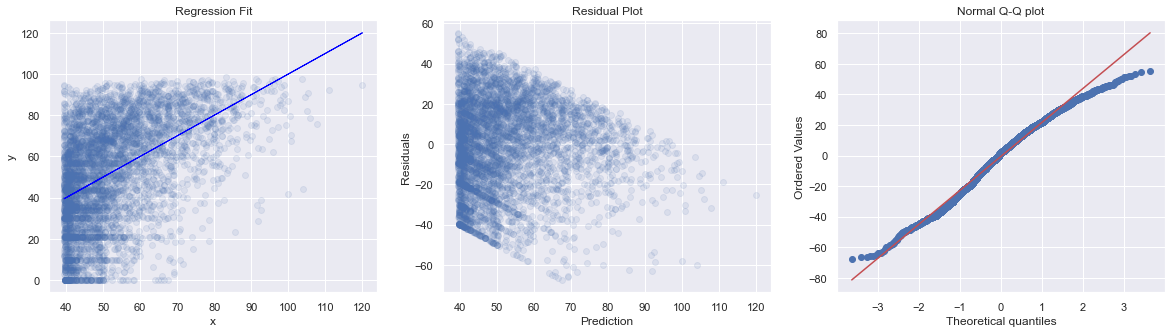

In [40]:
diagnostic_plot(lr_predict, y_test)

Looking at the **low accuracy** (low R^2 value) of both train/test data and the diagnostic plots, it can be seen that there is **underfitting** of the data. This may be because
- the models may not be suitable to capture the relationship.
- the points in our dataset have too much variation. There is still not much strong correlation between rating and the predictors chosen. 

However, the low accuracy may be normal because we are using **real-world data**. In reality, it may be that the factors that we are analyzing do not strongly influence whether a game is good or not.
- Predicting IMDB movie ratings with similarly many categorical variables using regression models using also seemed to give low accuracy: https://jazpeng.github.io/predict_movie_ratings/

Now, we will investigate the performance of other models and Gradient Boosting.

<a class="anchor" id="2.2"></a>
###  KNN Regression
KNN regression approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood **(nearest neighbors)**.

In [44]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 50)
knn.fit(X_train, y_train)

# Cross validation score of KNN model
cv_knn_train = cross_val_score(knn, X_train, y_train, cv = validation_type, scoring = "r2")
cv_knn_test = cross_val_score(knn, X_test, y_test, cv = validation_type, scoring = "r2")
print(f"train: {cv_knn_train}")
print(f"test: {cv_knn_test}")
print()
print(f"K-Nearest Neighbors Regression R^2 (train): {cv_knn_train.mean():.3f}")
print(f"K-Nearest Neighbors Regression R^2 (test): {cv_knn_test.mean():.3f}")

train: [0.29529096 0.30366585 0.25545574 0.26753107 0.26685825 0.29508003
 0.24546662 0.27778834 0.25228569 0.27211884]
test: [0.28102676 0.24513301 0.25651979 0.18036911 0.22617307 0.27998194
 0.22387733 0.25464639 0.23634903 0.28472616]

K-Nearest Neighbors Regression R^2 (train): 0.273
K-Nearest Neighbors Regression R^2 (test): 0.247


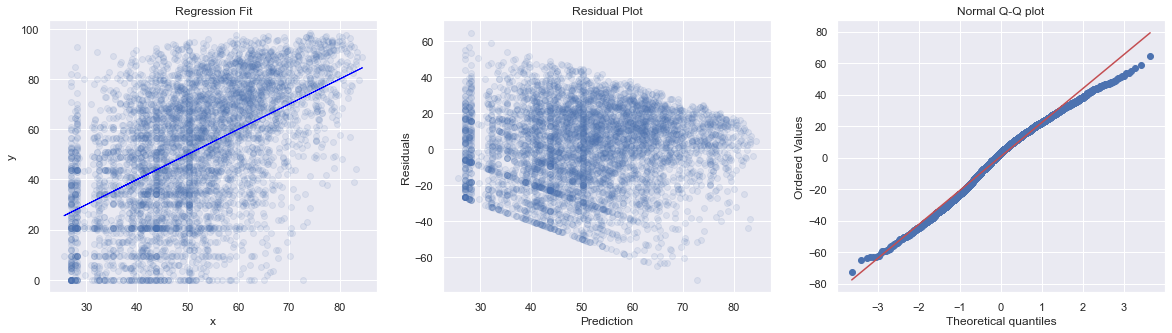

In [45]:
knn_predict = knn.predict(X_test)
diagnostic_plot(knn_predict, y_test)

<a class="anchor" id="2.3"></a>
### Random Forest Regressor
Random Forest fits a number of classifying **decision trees on various sub-samples** of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [46]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 69)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=69)

In [47]:
# Cross validation score of Random Forest Regressor model
cv_rf_train = cross_val_score(rf, X_train, y_train, cv = validation_type, scoring = "r2")
print(f"Random Forest Regressor R^2 (train): {cv_rf_train.mean():.3f}")
cv_rf_test = cross_val_score(rf, X_test, y_test, cv = validation_type, scoring = "r2")
print(f"Random Forest Regressor R^2 (test): {cv_rf_test.mean():.3f}")

Random Forest Regressor R^2 (train): 0.240
Random Forest Regressor R^2 (test): 0.195


In [48]:
rf_predict = rf.predict(X_test)
print(f"Random Forest Regressor MSE (test): {mean_squared_error(y_test, rf_predict):.3f}")
print(f"Random Forest Regressor RMSE (test): {np.sqrt(mean_squared_error(y_test, rf_predict)):.3f}")

Random Forest Regressor MSE (test): 489.955
Random Forest Regressor RMSE (test): 22.135


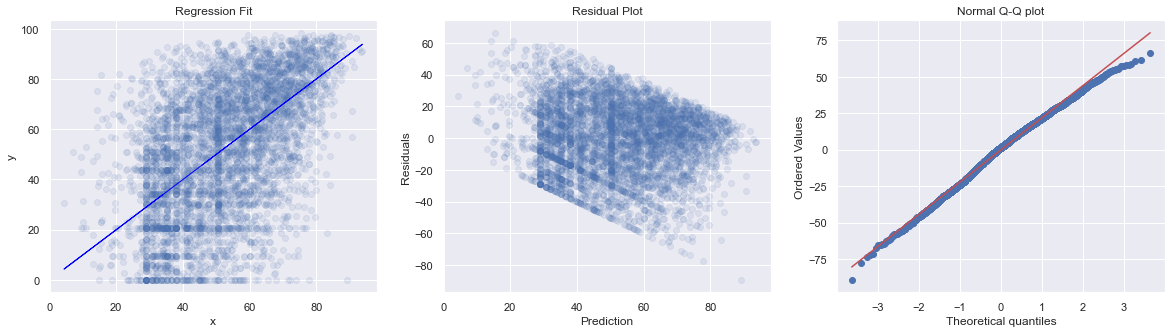

In [49]:
diagnostic_plot(rf_predict, y_test)

<a class="anchor" id="2.4"></a>
## Gradient Boosting Regression
Gradient Boosting uses a **loss function to be optimized**, a weak learner (eg. decision trees) to make predictions, and an additive model (gradient descent) to add weak learners to minimize the loss function.

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state = 69)
gbr.fit(X_train, y_train)

cv_gbr_train = cross_val_score(gbr, X_train, y_train, cv = validation_type, scoring = "r2")
cv_gbr_test = cross_val_score(gbr, X_test, y_test, cv = validation_type, scoring = "r2")
print(f"train: {cv_gbr_train}")
print(f"test: {cv_gbr_test}")
print()
print(f"Gradient Boosting Regression R^2 (train): {cv_gbr_train.mean():.3f}")
print(f"Gradient Boosting Regression R^2 (test): {cv_gbr_test.mean():.3f}")

train: [0.31849697 0.31894977 0.29211481 0.29798843 0.30025635 0.32101187
 0.28096999 0.31706466 0.28408591 0.30675246]
test: [0.31228898 0.26467389 0.28296622 0.20814383 0.29517399 0.31634905
 0.29964506 0.2871653  0.29328107 0.31772152]

Gradient Boosting Regression R^2 (train): 0.304
Gradient Boosting Regression R^2 (test): 0.288


In [51]:
# Predict test set and calculate mean squared error
gbr_predict = gbr.predict(X_test)
print(f"Gradient Boosting Regression MSE (test): {mean_squared_error(y_test, gbr_predict):.3f}")
print(f"Gradient Boosting Regression RMSE (test): {np.sqrt(mean_squared_error(y_test, gbr_predict)):.3f}")

Gradient Boosting Regression MSE (test): 455.145
Gradient Boosting Regression RMSE (test): 21.334


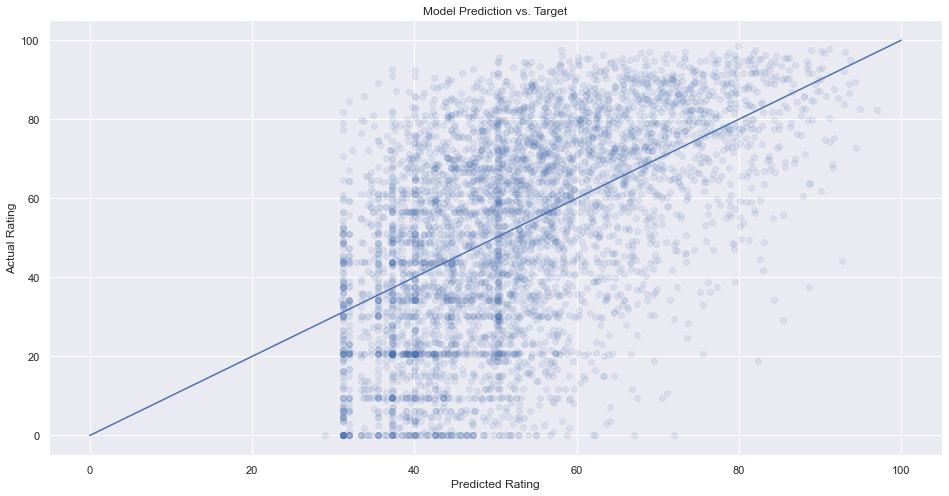

In [52]:
f = plt.figure(figsize=(16, 8))
plt.scatter(gbr_predict, y_test, alpha = 0.1)
plt.plot(np.linspace(0, 100), np.linspace(0, 100))
plt.title('Model Prediction vs. Target')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating');

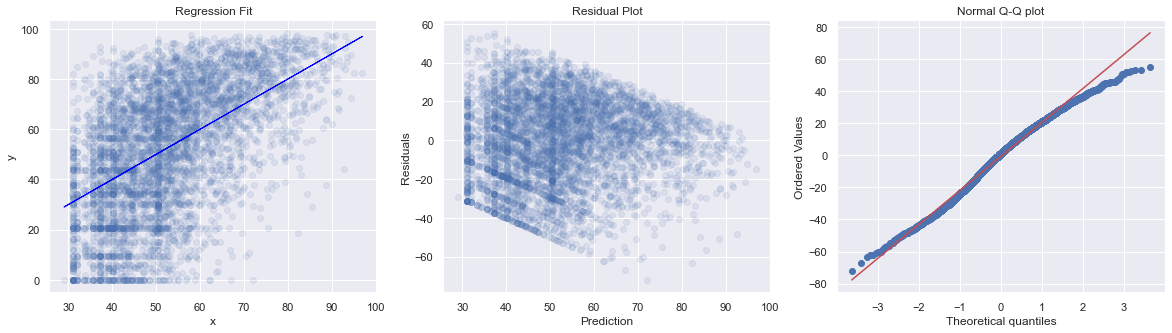

In [53]:
diagnostic_plot(gbr_predict, y_test)

Seems like **Gradient Boosting Regression** performs the best (highest R^2 value, lowest RMSE), with similar cross-validated train and test scores, indicating no over-fitting. We will use this model, and try to optimize the parameters.

In [54]:
## get feature importances
# pd.DataFrame(data = gbr.feature_importances_, index = X.columns, columns = ["importance"]).sort_values("importance", ascending = False)

### Optimizing Hyperparameters
To get the best parameters for our model, we use `GridSearchCV`, which runs exhaustive search over specified parameter values for an estimator.

In [55]:
parameters = {
    "n_estimators" :[50,100,250],
    "max_depth":[1,3,5],
    "learning_rate":[0.01,0.1,1],
    "subsample":[0.5,0.75,1]
}

In [56]:
# running this will take a while!
from sklearn.model_selection import GridSearchCV

GBR = GradientBoostingRegressor()
cv = GridSearchCV(GBR, parameters, cv = 3)
cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [1, 3, 5], 'n_estimators': [50, 100, 250],
                         'subsample': [0.5, 0.75, 1]})

In [57]:
# get best parameters
cv.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.75}

In [58]:
# use best parameters found
gbr = GradientBoostingRegressor(**cv.best_params_)
gbr.fit(X_train, y_train)

cv_gbr_train = cross_val_score(gbr, X_train, y_train, cv = validation_type, scoring = "r2")
cv_gbr_test = cross_val_score(gbr, X_test, y_test, cv = validation_type, scoring = "r2")
print(f"train: {cv_gbr_train}")
print(f"test: {cv_gbr_test}")
print()
print(f"Gradient Boosting Regression R^2 (train): {cv_gbr_train.mean():.3f}")
print(f"Gradient Boosting Regression R^2 (test): {cv_gbr_test.mean():.3f}")

# Predict test set and calculate mean squared error
gbr_predict = gbr.predict(X_test)
print(f"Gradient Boosting Regression MSE (test): {mean_squared_error(y_test, gbr_predict):.3f}")
print(f"Gradient Boosting Regression RMSE (test): {np.sqrt(mean_squared_error(y_test, gbr_predict)):.3f}")

train: [0.33014343 0.32264129 0.29699667 0.29723295 0.3033402  0.33694397
 0.29287003 0.32443874 0.29696313 0.31833456]
test: [0.28522315 0.25419379 0.28711999 0.1957681  0.29659388 0.33115704
 0.28443891 0.29892936 0.29276723 0.32159956]

Gradient Boosting Regression R^2 (train): 0.312
Gradient Boosting Regression R^2 (test): 0.285
Gradient Boosting Regression MSE (test): 446.891
Gradient Boosting Regression RMSE (test): 21.140


Slightly better accuracy! Maybe better parameters could be found, but it will take up too much processing power and time.

<a class="anchor" id="2.5"></a>
### Using Descriptions of games to predict Rating 
Do the descriptions of a game affect the rating of a game? 
- First, we use `NLTK` to normalize the text data using stemming and lemmatization, which reduce words to their root. eg. featuring/features/featured => featur
- Then, we will use **TF-IDF** (term frequency-inverse document frequency) to vectorize our text data so that we can use them as predictors in our regression model. TF-IDF uses the frequency of words to determine how relevant those words are to a given document.

In [59]:
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *

p_stemmer = PorterStemmer()

def nltk_process(text):
    # Tokenization
    nltk_tokenList = word_tokenize(text)
    
    # Stemming
    nltk_stemedList = []
    for word in nltk_tokenList:
        nltk_stemedList.append(p_stemmer.stem(word))
    
    # Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    nltk_lemmaList = []
    for word in nltk_stemedList:
        nltk_lemmaList.append(wordnet_lemmatizer.lemmatize(word))
        
    return " ".join(nltk_lemmaList)
    
var["description_clean"] = var["description_clean"].apply(nltk_process)
var["name_clean"] = var["name_clean"].apply(nltk_process)

In [60]:
text = var[["description_clean", "rating"]]

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorize text data using TF-IDF
tfidf = TfidfVectorizer(analyzer="word", stop_words=sw, max_features = 200)
tfidf_description = tfidf.fit_transform(text["description_clean"])
description_df = pd.DataFrame(data = tfidf_description.toarray(), columns = tfidf.get_feature_names_out())

text = pd.concat([description_df, text], axis = "columns")

In [62]:
# X is inputs, y is output
text_X = text.drop(["rating", "description_clean"], axis = 1)
text_y = text["rating"] 

# Splitting into train and test data
text_X_train, text_X_test, text_y_train, text_y_test = train_test_split(text_X, text_y, test_size = 0.2, random_state = 69) 

text_lr = LinearRegression()
text_lr.fit(text_X_train, text_y_train)

LinearRegression()

In [63]:
# Cross validation score of Linear Regression model
cv_text_lr_train = cross_val_score(text_lr, text_X_train, text_y_train, cv = validation_type, scoring = "r2")
cv_text_lr_test = cross_val_score(text_lr, text_X_test, text_y_test, cv = validation_type, scoring = "r2")
print(f"train: {cv_text_lr_train}")
print(f"test: {cv_text_lr_test}")
print()
print(f"Linear Regression R^2 (train): {cv_text_lr_train.mean():.3f}")
print(f"Linear Regression R^2 (test): {cv_text_lr_test.mean():.3f}")

train: [0.06217774 0.05531997 0.03238731 0.02147349 0.03827842 0.05201675
 0.0338911  0.05240941 0.02771441 0.03964784]
test: [ 0.03402613 -0.00501227 -0.00763608  0.01100961 -0.02667185  0.02082251
 -0.01109942 -0.0371484   0.04435396  0.00241482]

Linear Regression R^2 (train): 0.042
Linear Regression R^2 (test): 0.003


A super low accuracy! Looks like we **are not able to predict the rating of a game by its description alone**, there's not much correlation between the words used and the rating of the game...

<a class="anchor" id="3"></a>
# Classification Models

Next, we will try using classification for our problem instead. Using the `rating` of a game, we will create a new column to identify whether a game `is_good` or not.
First, we will need to handle the imbalanced data. 
- If the unequal distribution of classes is not treated beforehand, it will reduce the performance of the classifier model. Most of the predictions will correspond to the majority class and treat the minority class features as noise in the data and ignore them, leading to a high bias in the model. 

Hence, we will resample the data using **SMOTE ENN** (Synthetic Minority Oversampling Technique + Edited Nearest Neighbor). SMOTE ENN combines both oversampling (SMOTE) and undersampling (ENN).

- SMOTE: chooses a random example from the minority class and finds its nearest neighbours. A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.
- ENN: uses k=3 nearest neighbors to locate misclassified examples in a dataset and which are then removed before a k=1 classification rule is applied. 

Then, We will do a 80:20 `train_test_split` for our data and investigate the performance of various classification models.

In [64]:
# classify game as a good game if it has rating within the top 10%
var["is_good"] = (var["rating"] >= var["rating"].quantile(0.9)).astype(int)

### Resampling Data

Text(0.5, 0, 'is_good (before SMOTE ENN)')

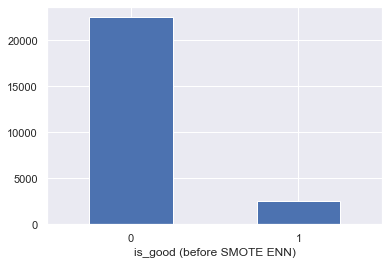

In [79]:
var["is_good"].value_counts().plot(kind = "bar", rot = 0).set_xlabel("is_good (before SMOTE ENN)")

Here, we can clearly see that there is a huge **imbalance** in the data, as there are way more datapoints of `is_good = 0` than `is_good = 1`.

In [66]:
# X is inputs, y is output
c_X = var.drop(["rating", "steam_appid", "year", "owners", "description_clean", "name_clean", "is_good"], axis = 1)
c_X = c_X.loc[:,:"Strategy"] # get columns without additional tags
c_y = var["is_good"] 

In [67]:
# Splitting into train and test data
c_X_train, c_X_test, c_y_train, c_y_test = train_test_split(c_X, c_y, test_size = 0.2, random_state = 69) 

In [68]:
from imblearn.combine import SMOTEENN

# resample data using SMOTE ENN
smote_enn = SMOTEENN()
c_X_train, c_y_train = smote_enn.fit_resample(c_X_train, c_y_train)

Text(0.5, 0, 'is_good (after SMOTE ENN)')

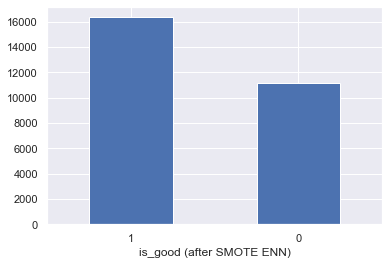

In [80]:
c_y_train.value_counts().plot(kind = "bar", rot = 0).set_xlabel("is_good (after SMOTE ENN)")

Data is more balanced now!

<a class="anchor" id="3.1"></a>
### Logistic Regression
Logistic regression is a statistical method for predicting binary classes, it models the probability of a discrete outcome given an input variable. It uses a logit function, applying a sigmoid function onto linear regression.

In [71]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression(max_iter = 1000, random_state = 69)
logr.fit(c_X_train, c_y_train)

logr_test_pred = logr.predict(c_X_test)
logr_train_pred = logr.predict(c_X_train)

In [72]:
from sklearn.metrics import confusion_matrix, classification_report

# print confusion matrix and metrics of a classification model
def get_metrics(y_train, y_train_pred, y_test, y_test_pred):
    print("Goodness of Fit of Model \tTrain Dataset")
    cf_train = confusion_matrix(y_train, y_train_pred)
    TPR_train = cf_train[1][1] / (cf_train[1][1] + cf_train[1][0])
    FPR_train = cf_train[0][1] / (cf_train[0][1] + cf_train[0][0])
    print(f"True Positive Rate \t\t: {TPR_train:.3f}")
    print(f"True Negative Rate \t\t: {1 - FPR_train:.3f}")
    print()

    print("Goodness of Fit of Model \tTest Dataset")
    cf_test = confusion_matrix(y_test, y_test_pred)
    TPR_test = cf_test[1][1] / (cf_test[1][1] + cf_test[1][0])
    FPR_test = cf_test[0][1] / (cf_test[0][1] + cf_test[0][0])
    print(f"True Positive Rate \t\t: {TPR_test:.3f}")
    print(f"True Negative Rate \t\t: {1 - FPR_test:.3f}")

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusion_matrix(y_train, y_train_pred),
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0]).set_title("Train Dataset")
    sb.heatmap(confusion_matrix(y_test, y_test_pred), 
               annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1]).set_title("Test Dataset")
    plt.show()
    
    print("train: ")
    print(classification_report(y_train, y_train_pred, zero_division = 0))
    print()
    print("test: ")
    print(classification_report(y_test, y_test_pred, zero_division = 0))

Goodness of Fit of Model 	Train Dataset
True Positive Rate 		: 0.861
True Negative Rate 		: 0.718

Goodness of Fit of Model 	Test Dataset
True Positive Rate 		: 0.654
True Negative Rate 		: 0.646


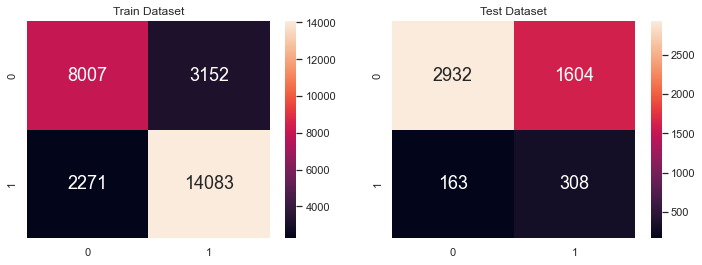

train: 
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     11159
           1       0.82      0.86      0.84     16354

    accuracy                           0.80     27513
   macro avg       0.80      0.79      0.79     27513
weighted avg       0.80      0.80      0.80     27513


test: 
              precision    recall  f1-score   support

           0       0.95      0.65      0.77      4536
           1       0.16      0.65      0.26       471

    accuracy                           0.65      5007
   macro avg       0.55      0.65      0.51      5007
weighted avg       0.87      0.65      0.72      5007



In [73]:
get_metrics(c_y_train, logr_train_pred, c_y_test, logr_test_pred)

- Precision - measure of a classifier’s exactness. For each class, it is defined as the ratio of true positives to the sum of true and false positives. 
- Recall - measure of the classifier’s completeness and ability to correctly find all positive instances. For each class, it is defined as the ratio of true positives to the sum of true positives and false negatives. 
- F1-score - weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1-scores are lower than accuracy measures as they embed precision and recall into their computation. 
- Support - the number of actual occurrences of the class in the specified dataset. 

Much **higher accuracy for both train and test than our regression models**! In predicting the goodness of a game using models, it seems that approaching the problem with classification will give better accuracy than regression.
- This may be because our classification model only needs to predict discrete labels (0 or 1) but our regression model needs to predict an exact continuous value (0-100) which is more difficult to be accurately predict.

However, accuracy may not be the best measure especially with an unbalanced datset. Hence, we will look at the **f1-score**, accounts for precision and recall.
- However, train has a high f1-score but test has a low f1-score in predicting the class of 1, indicating overfitting on the train dataset.

<a class="anchor" id="3.2"></a>
### Random Forest Classifier
Random Forest Classifier fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [74]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 69)
rfc.fit(c_X_train, c_y_train)

rfc_test_pred = rfc.predict(c_X_test)
rfc_train_pred = rfc.predict(c_X_train)

Goodness of Fit of Model 	Train Dataset
True Positive Rate 		: 0.992
True Negative Rate 		: 0.992

Goodness of Fit of Model 	Test Dataset
True Positive Rate 		: 0.548
True Negative Rate 		: 0.788


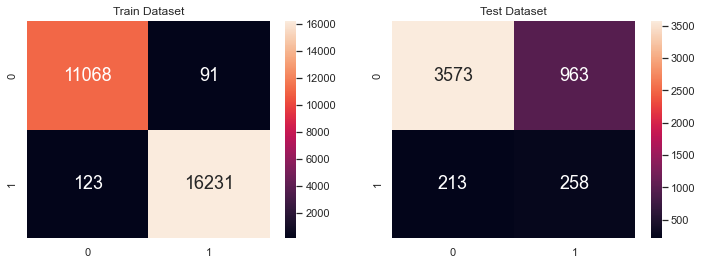

train: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     11159
           1       0.99      0.99      0.99     16354

    accuracy                           0.99     27513
   macro avg       0.99      0.99      0.99     27513
weighted avg       0.99      0.99      0.99     27513


test: 
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      4536
           1       0.21      0.55      0.30       471

    accuracy                           0.77      5007
   macro avg       0.58      0.67      0.58      5007
weighted avg       0.87      0.77      0.81      5007



In [75]:
get_metrics(c_y_train, rfc_train_pred, c_y_test, rfc_test_pred)

The Random Forest Classifier gives better accuracy and f1-score than Logistic Regression.

In [76]:
# feature importances
pd.DataFrame(rfc.feature_importances_, index = rfc.feature_names_in_, columns = ["importance"]).sort_values("importance", ascending = False)

,importance
initialprice,0.243801
achievements,0.217364
languages,0.107426
Casual,0.052326
platforms,0.049454
Simulation,0.045095
Action,0.044375
Strategy,0.042704
Adventure,0.033860
movies,0.025449


Sorted feature importances of determining whether a game is good or not, with `initialprice` being the most important feature.

<a class="anchor" id="4"></a>
## Conclusion

- In predicting the goodness of a game, our classification models have much higher accuracies than our regression models. This is possibly because it is easier to make accurate predictions for discrete values (game is good or not) rather than continuous values (rating).
- For regression, the best model for our dataset in predicting the rating of a game is a Gradient Boosted Regressor. For classification, the Random Forest Classifier performs better in predicting whether a game is good or not.
- Using regression, we are unable to accurately predict the rating of a game (30% accuracy) using our current dataset. The current features that we have investigated (eg. genres, descriptions) do not have much influence on the rating of a game. Currently, some of the most important features of a good game are price, controller support, high platform and language support. We may need other factors (that the data might not be as easily accessible) to make better predictions, such as budget of the game.
- In the game industry, the number of games and the number of good games have both been increasing exponentially over the years. But, there is an increasingly huge proportion of smaller games made by indie devs that are of lower quality. This may also be skewing our data.